# I. Import Libraries, Preferences, and Helper 
### (Note - each library are imported separately in separate files, such as in preprocess.py, ab.py, inputs.py, main.py, etc.)
### (Note 2 - this notebook is for documentation purposes only, actual processes were done in separate files and directories)

In [37]:
import os
import numpy as np
import pandas as pd
import joblib
import inquirer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Import classifiers
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Load the dataset
#### Original Dataset URL - https://catalog.data.gov/dataset/warehouse-and-retail-sales

In [17]:
# Load Dataset
DATASETURL = "https://data.montgomerycountymd.gov/api/views/v76h-r7br/rows.csv"
df = pd.read_csv(DATASETURL)

# II. Exploratory Data Analysis

In [18]:
# Summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB


In [19]:
# Descriptive Statistics
df.describe()

,YEAR,MONTH,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,307645.000000,307645.000000,307642.000000,307645.000000,307645.000000
mean,2018.438525,6.423862,7.024071,6.936465,25.294597
std,1.083061,3.461812,30.986238,30.237195,249.916798
min,2017.000000,1.000000,-6.490000,-38.490000,-7800.000000
25%,2017.000000,3.000000,0.000000,0.000000,0.000000
50%,2019.000000,7.000000,0.320000,0.000000,1.000000
75%,2019.000000,9.000000,3.267500,3.000000,5.000000
max,2020.000000,12.000000,2739.000000,1990.830000,18317.000000


In [20]:
# First five data
df.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0


In [25]:
# Check for Missing Values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

SUPPLIER        167
ITEM TYPE         1
RETAIL SALES      3
dtype: int64


# III. Preprocessing of data

In [22]:
# Drop Item Description, Supplier, and Item Type
data = df.drop(['ITEM DESCRIPTION', 'SUPPLIER', 'ITEM TYPE'], axis=1, errors='ignore') 

# Classify into 3 categories: Low (0), Medium (1), High (2)
data['DEMAND CLASS'] = pd.qcut(data['RETAIL SALES'], q=3, labels=[0, 1, 2])

# Remove non-numeric, non-integer data because it contains string data such as WC and BC
data = data[~data['ITEM CODE'].isin(['WC', 'BC'])]
data['ITEM CODE'] = pd.to_numeric(data['ITEM CODE'], errors='coerce')
data = data.dropna(subset=['ITEM CODE'])
data['ITEM CODE'] = data['ITEM CODE'].astype(int)

# Drop Retail Sales since it's replaced by demand class
data = data.drop(['RETAIL SALES'], axis=1, errors='ignore') 

# Fill any missing numeric data
data.fillna(0, inplace=True)

# Save the preprocessed data
directory = 'datasets'

# Save the preprocessed data to datasets directory
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the dataset as preprocessed.csv into datasets directory
filepath = os.path.join(directory, 'preprocessed documentation.csv')

# Convert sales dataframe to csv dataset
data.to_csv(filepath, index=False)

In [29]:
# Load the preprocessed data info
preprocessed_data = pd.read_csv('datasets\preprocessed documentation.csv')

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\johnh\AppData\Local\Temp\ipykernel_17456\3102444598.py:2: SyntaxWarning: invalid escape sequence '\p'
  preprocessed_data = pd.read_csv('datasets\preprocessed documentation.csv')


In [30]:
# Summary of the preprocessed data
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307591 entries, 0 to 307590
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307591 non-null  int64  
 1   MONTH             307591 non-null  int64  
 2   ITEM CODE         307591 non-null  int64  
 3   RETAIL TRANSFERS  307591 non-null  float64
 4   WAREHOUSE SALES   307591 non-null  float64
 5   DEMAND CLASS      307591 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 14.1 MB


In [33]:
# Descriptive Statistics of the preprocessed data
preprocessed_data.describe()

,YEAR,MONTH,ITEM CODE,RETAIL TRANSFERS,WAREHOUSE SALES,DEMAND CLASS
count,307591.000000,307591.000000,3.075910e+05,307591.000000,307591.000000,307591.000000
mean,2018.438534,6.423949,1.641144e+05,6.937653,25.340248,0.936471
std,1.083067,3.461788,1.361148e+05,30.239715,249.853587,0.850978
min,2017.000000,1.000000,2.000000e+00,-38.490000,-7800.000000,0.000000
25%,2017.000000,3.000000,4.810400e+04,0.000000,0.000000,0.000000
50%,2019.000000,7.000000,8.402300e+04,0.000000,1.000000,1.000000
75%,2019.000000,9.000000,3.180870e+05,3.000000,5.000000,2.000000
max,2020.000000,12.000000,3.480003e+06,1990.830000,18317.000000,2.000000


In [34]:
# First five data of the preprocessed data
preprocessed_data.head()

,YEAR,MONTH,ITEM CODE,RETAIL TRANSFERS,WAREHOUSE SALES,DEMAND CLASS
0,2020,1,100009,0.0,2.0,0
1,2020,1,100024,1.0,4.0,0
2,2020,1,1001,0.0,1.0,0
3,2020,1,100145,0.0,1.0,0
4,2020,1,100293,0.0,0.0,1


In [35]:
# Check for Missing Values of preprocessed data
missing_values = preprocessed_data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


# IV. Visualization

C:\Users\johnh\AppData\Local\Temp\ipykernel_17456\1236632584.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=preprocessed_data, x='DEMAND CLASS', palette='viridis')


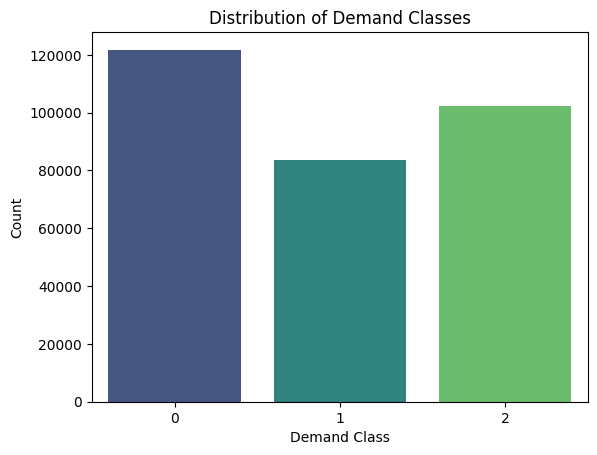

In [50]:
# Count Plot of Demand Classes
sns.countplot(data=preprocessed_data, x='DEMAND CLASS', palette='viridis')
plt.title("Distribution of Demand Classes")
plt.xlabel("Demand Class")
plt.ylabel("Count")
plt.show()

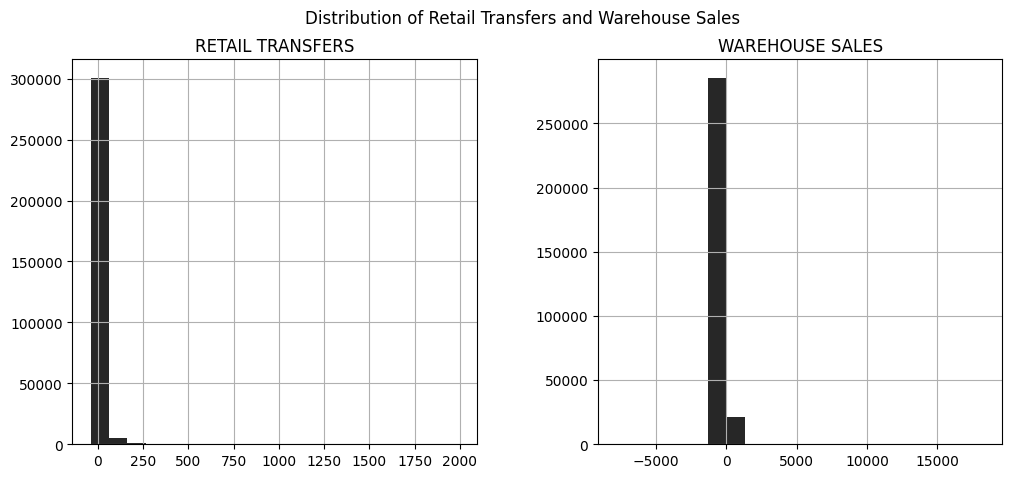

In [51]:
# Histograms for Retail Transfers and Warehouse Sales
preprocessed_data[['RETAIL TRANSFERS', 'WAREHOUSE SALES']].hist(bins=20, figsize=(12, 5), color=['#272727'])
plt.suptitle("Distribution of Retail Transfers and Warehouse Sales")
plt.show()

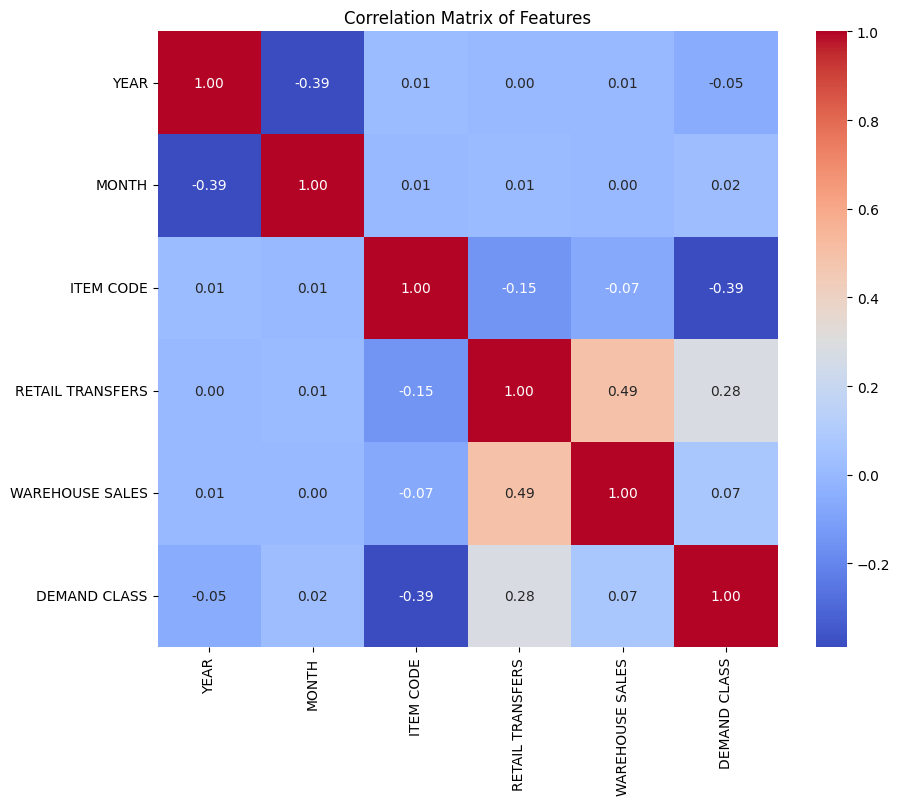

In [52]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = preprocessed_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

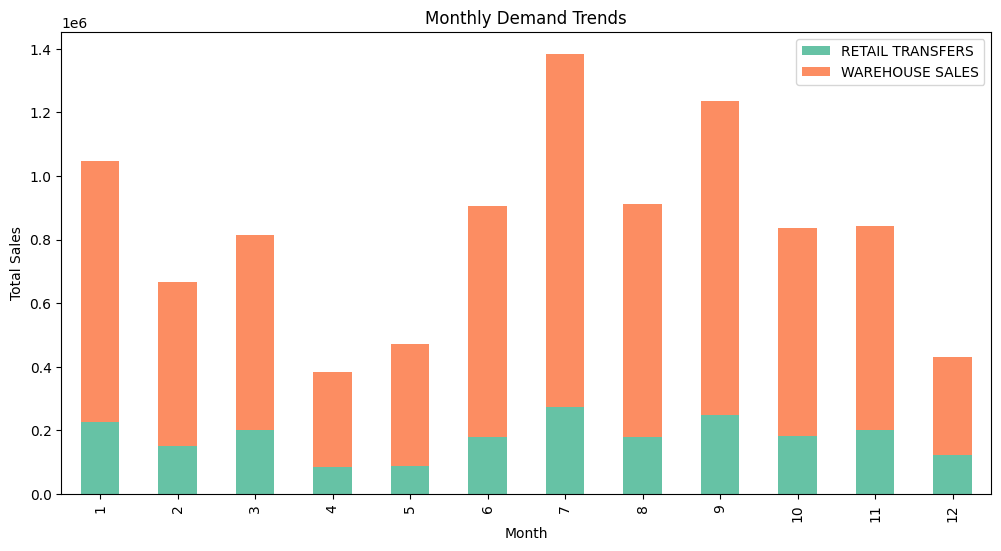

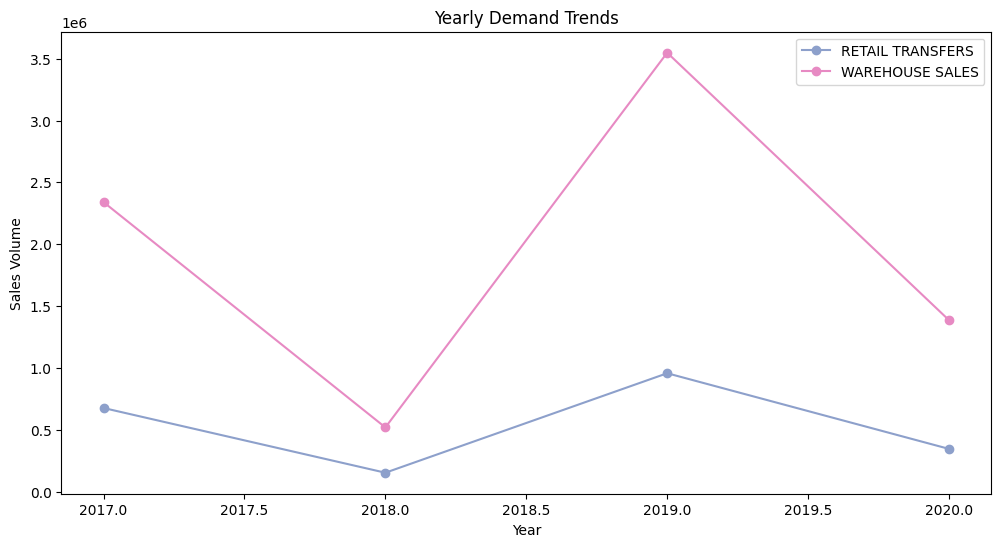

In [56]:
# Monthly Trend Visualization
monthly_trend = preprocessed_data.groupby('MONTH')[['RETAIL TRANSFERS', 'WAREHOUSE SALES']].sum()
monthly_trend.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#66c2a5', '#fc8d62'])
plt.title('Monthly Demand Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

# Yearly Trend Visualization
yearly_trend = preprocessed_data.groupby('YEAR')[['RETAIL TRANSFERS', 'WAREHOUSE SALES']].sum()
yearly_trend.plot(kind='line', marker='o', figsize=(12, 6), color=['#8da0cb', '#e78ac3'])
plt.title('Yearly Demand Trends')
plt.xlabel('Year')
plt.ylabel('Sales Volume')
plt.show()


C:\Users\johnh\AppData\Local\Temp\ipykernel_17456\39051058.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=preprocessed_data, x='DEMAND CLASS', y='RETAIL TRANSFERS', palette='viridis')


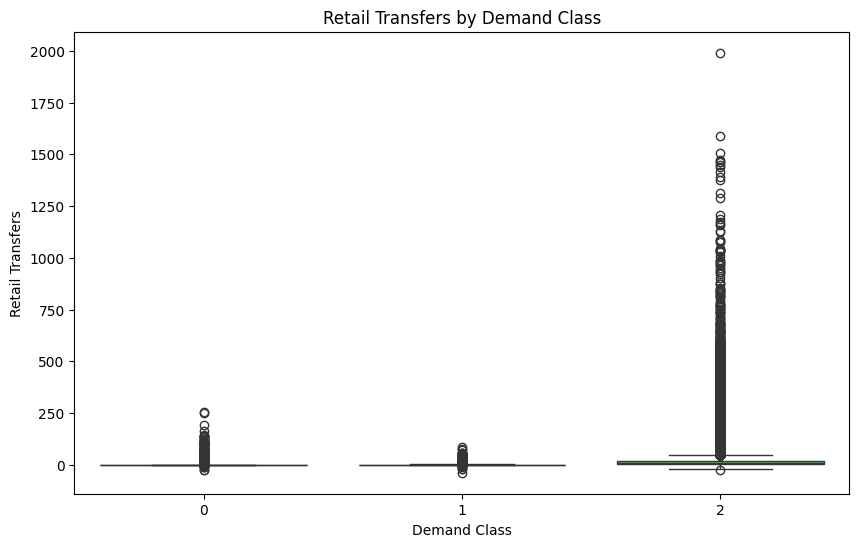

C:\Users\johnh\AppData\Local\Temp\ipykernel_17456\39051058.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=preprocessed_data, x='DEMAND CLASS', y='WAREHOUSE SALES', palette='viridis')


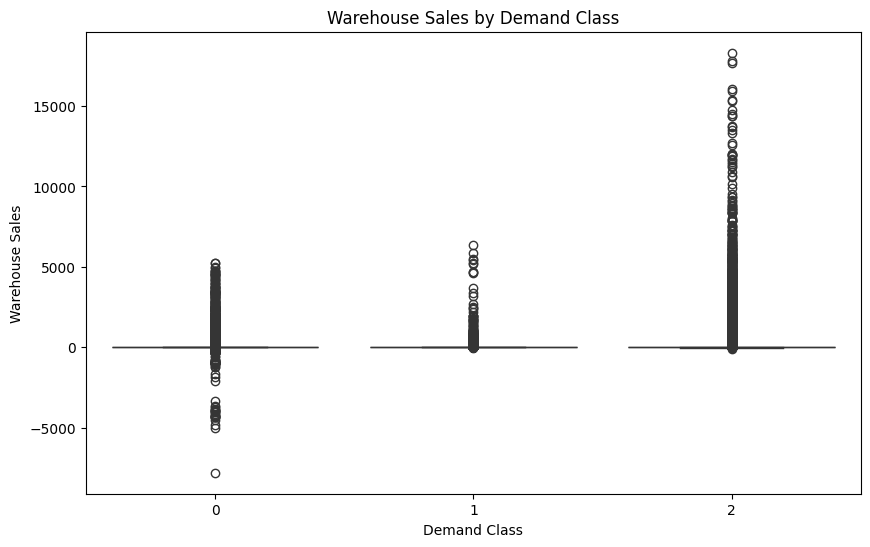

In [57]:
# Box Plot for Retail Transfers by Demand Class
plt.figure(figsize=(10, 6))
sns.boxplot(data=preprocessed_data, x='DEMAND CLASS', y='RETAIL TRANSFERS', palette='viridis')
plt.title("Retail Transfers by Demand Class")
plt.xlabel("Demand Class")
plt.ylabel("Retail Transfers")
plt.show()

# Box Plot for Warehouse Sales by Demand Class
plt.figure(figsize=(10, 6))
sns.boxplot(data=preprocessed_data, x='DEMAND CLASS', y='WAREHOUSE SALES', palette='viridis')
plt.title("Warehouse Sales by Demand Class")
plt.xlabel("Demand Class")
plt.ylabel("Warehouse Sales")
plt.show()


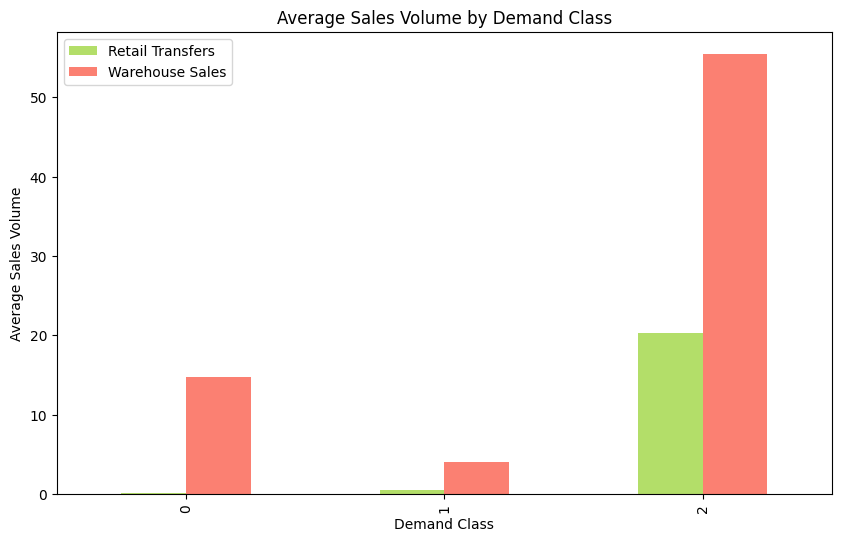

In [58]:
# Bar Plot for Average Sales Volume by Demand Class
avg_sales = preprocessed_data.groupby('DEMAND CLASS')[['RETAIL TRANSFERS', 'WAREHOUSE SALES']].mean()
avg_sales.plot(kind='bar', figsize=(10, 6), color=['#b3de69', '#fb8072'])
plt.title("Average Sales Volume by Demand Class")
plt.xlabel("Demand Class")
plt.ylabel("Average Sales Volume")
plt.legend(['Retail Transfers', 'Warehouse Sales'])
plt.show()

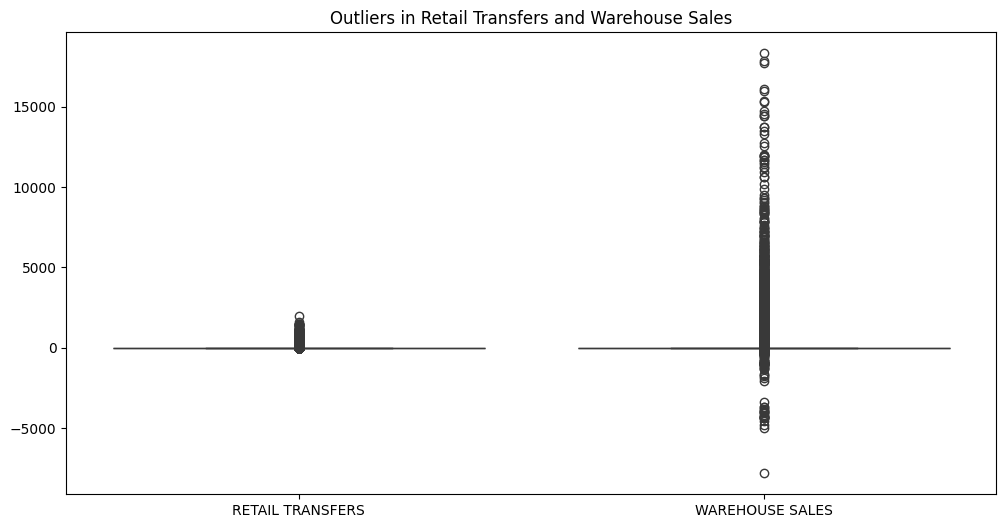

In [59]:
# Box Plot for Outliers in Retail Transfers and Warehouse Sales
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['RETAIL TRANSFERS', 'WAREHOUSE SALES']], palette="viridis")
plt.title("Outliers in Retail Transfers and Warehouse Sales")
plt.show()


# V. Model Development and Model Evaluation
### (Note - Models were developed in a separate directory (models) and in separate files)
### (Note 2 - Model Development and Model Evaluation in same chapter)

#### AdaBoost

In [61]:
# Constants
DATASET = 'datasets/preprocessed documentation.csv'
MODEL_DIR = 'models'
MODEL_PATH = os.path.join(MODEL_DIR, 'ab.pkl')

# Load the dataset
data = pd.read_csv(DATASET)

# Features and Target
features = [
    'YEAR',
    'MONTH',
    'ITEM CODE',
    'RETAIL TRANSFERS',
    'WAREHOUSE SALES'
]
target = 'DEMAND CLASS'

# Train the model
X = np.asarray(data[features])
y = np.asarray(data[target])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the AdaBoost model using the default base estimator
model = AdaBoostClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
# joblib.dump(model, MODEL_PATH) (commented to avoid duplication, since models are already developed in a separate file)


c:\Users\johnh\Desktop\swdsnlabfinals\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.97      0.90     24210
           1       0.78      0.69      0.73     16895
           2       0.91      0.83      0.87     20414

    accuracy                           0.84     61519
   macro avg       0.84      0.83      0.83     61519
weighted avg       0.84      0.84      0.84     61519



#### CatBoost

In [62]:
# Constants
DATASET = 'datasets/preprocessed documentation.csv'
MODEL_DIR = 'models'
MODEL_PATH = os.path.join(MODEL_DIR, 'cb.pkl')

# Load the dataset
data = pd.read_csv(DATASET)

# Feature Engineering - SPLIT
features = [
    'YEAR',
    'MONTH',
    'ITEM CODE',
    'RETAIL TRANSFERS',
    'WAREHOUSE SALES',
]
target = 'DEMAND CLASS'

# Train the model
X = np.asarray(data[features])
y = np.asarray(data[target])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the model
model = CatBoostClassifier(iterations=100, random_state=42, verbose=0) 
model.fit(X_train, y_train)

# Evaluate the model 
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
# joblib.dump(model, MODEL_PATH) (commented to avoid duplication, since models are already developed in a separate file)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     24210
           1       0.77      0.75      0.76     16895
           2       0.91      0.83      0.87     20414

    accuracy                           0.86     61519
   macro avg       0.85      0.85      0.85     61519
weighted avg       0.86      0.86      0.86     61519



#### Gradient Boosting Machine

In [63]:
# Constants
DATASET = 'datasets/preprocessed documentation.csv'
MODEL_DIR = 'models'
MODEL_PATH = os.path.join(MODEL_DIR, 'gbm.pkl')

# Load the dataset
data = pd.read_csv(DATASET)

# Feature Engineering - SPLIT
features = [
    'YEAR',
    'MONTH',
    'ITEM CODE',
    'RETAIL TRANSFERS',
    'WAREHOUSE SALES',
]
target = 'DEMAND CLASS'

# Train the model
X = np.asarray(data[features])
y = np.asarray(data[target])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model 
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
# joblib.dump(model, MODEL_PATH) (commented to avoid duplication, since models are already developed in a separate file)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     24210
           1       0.77      0.74      0.75     16895
           2       0.92      0.82      0.87     20414

    accuracy                           0.86     61519
   macro avg       0.85      0.84      0.85     61519
weighted avg       0.86      0.86      0.86     61519



#### K-Nearest Neighbors

In [64]:
import pandas as pd 
import numpy as np 
import os 
import joblib 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Constants
DATASET = 'datasets/preprocessed documentation.csv'
MODEL_DIR = 'models'
MODEL_PATH = os.path.join(MODEL_DIR, 'k-nn.pkl')

# Load the dataset
data = pd.read_csv(DATASET)

# Feature Engineering - SPLIT
features = [
    'YEAR',
    'MONTH',
    'ITEM CODE',
    'RETAIL TRANSFERS',
    'WAREHOUSE SALES',
]
target = 'DEMAND CLASS'

# Train the model
X = np.asarray(data[features])
y = np.asarray(data[target])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
model.fit(X_train, y_train)

# Evaluate the model 
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
# joblib.dump(model, MODEL_PATH) (commented to avoid duplication, since models are already developed in a separate file)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     24210
           1       0.73      0.77      0.75     16895
           2       0.90      0.83      0.86     20414

    accuracy                           0.84     61519
   macro avg       0.83      0.83      0.83     61519
weighted avg       0.84      0.84      0.84     61519



#### Light Gradient-Boosting-Machine (LGBM)

In [65]:
import pandas as pd 
import numpy as np 
import os 
import joblib 
from sklearn.model_selection import train_test_split 
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Constants
DATASET = 'datasets/preprocessed documentation.csv'
MODEL_DIR = 'models'
MODEL_PATH = os.path.join(MODEL_DIR, 'lgbm.pkl')

# Load the dataset
data = pd.read_csv(DATASET)

# Feature Engineering - SPLIT
features = [
    'YEAR',
    'MONTH',
    'ITEM CODE',
    'RETAIL TRANSFERS',
    'WAREHOUSE SALES',
]
target = 'DEMAND CLASS'

# Train the model
X = np.asarray(data[features])
y = np.asarray(data[target])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the model
model = LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model 
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
# joblib.dump(model, MODEL_PATH) (commented to avoid duplication, since models are already developed in a separate file)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 246072, number of used features: 5
[LightGBM] [Info] Start training from score -0.925218
[LightGBM] [Info] Start training from score -1.305284
[LightGBM] [Info] Start training from score -1.101237
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     24210
           1       0.77      0.74      0.76     16895
           2       0.91      0.83      0.87     20414

    accuracy                           0.86     61519
   macro avg       0.85      0.85      0.85     61519
weighted avg       0.86      0.86      0.86     61519



#### Extreme Gradient Boosting (XGB)

In [ ]:
import pandas as pd 
import numpy as np 
import os 
import joblib 
from sklearn.model_selection import train_test_split 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Constants
DATASET = 'datasets/preprocessed documentation.csv'
MODEL_DIR = 'models'
MODEL_PATH = os.path.join(MODEL_DIR, 'xgb.pkl')

# Load the dataset
data = pd.read_csv(DATASET)

# Feature Engineering - SPLIT
features = [
    'YEAR',
    'MONTH',
    'ITEM CODE',
    'RETAIL TRANSFERS',
    'WAREHOUSE SALES',
]
target = 'DEMAND CLASS'

# Train the model
X = np.asarray(data[features])
y = np.asarray(data[target])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the model
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model 
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model
# joblib.dump(model, MODEL_PATH)(commented to avoid duplication, since models are already developed in a separate file)